In [1]:
import pandas as pd
import numpy as np
import time

import datetime
import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_val_score

import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor,  StackingRegressor
#from lazypredict.Supervised import LazyRegressor

from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_absolute_error

## Осмотр данных

In [3]:
train = pd.read_csv('new_train.csv', low_memory=False, encoding='utf-8')
train.head()

,bodyType,brand,color,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,WAGON_5_DOORS,VAZ,007F00,"Авто приобреталось для работы , ездил каждый д...",1596.0,98.0,{},GASOLINE,189000,2007.0,...,WAGON_5_DOORS,MECHANICAL,RUSSIAN,4.0,2009,ORIGINAL,FORWARD_CONTROL,LEFT,NaN,True
1,LIFTBACK,VAZ,FAFBFB,Один владелец!!! Оригинал ПТС!!! Усилитель рул...,1596.0,87.0,"{'steel-wheels': True, 'condition': True, 'abs...",GASOLINE,72000,2011.0,...,LIFTBACK,MECHANICAL,RUSSIAN,1.0,2017,ORIGINAL,FORWARD_CONTROL,LEFT,NaN,True
2,SEDAN,VAZ,FAFBFB,Сделка проходит под полным контролем сотрудник...,1596.0,106.0,"{'glonass': True, 'tinted-glass': True, 'steel...",GASOLINE,42000,2018.0,...,SEDAN,ROBOT,RUSSIAN,1.0,2018,ORIGINAL,FORWARD_CONTROL,LEFT,NaN,True
3,ALLROAD_3_DOORS,VAZ,007F00,"Машина с организации, продажа за наличку. Авто...",1900.0,75.0,{},DIESEL,117000,1993.0,...,ALLROAD_3_DOORS,MECHANICAL,RUSSIAN,3.0,2009,DUPLICATE,ALL_WHEEL_DRIVE,LEFT,NaN,True
4,SEDAN,VAZ,0000CC,ЛАДА–ЦЕНТР — Дилер № 1 в Санкт-Петербурге!\r\n...,1596.0,106.0,"{'glonass': True, 'asr': True, 'tinted-glass':...",GASOLINE,0,2015.0,...,SEDAN,ROBOT,RUSSIAN,NaN,2021,ORIGINAL,FORWARD_CONTROL,LEFT,NaN,True


In [4]:
train.replace(to_replace=['None'], value=np.nan, inplace=True)
train.drop_duplicates(inplace=True)
train.shape

(187955, 26)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187955 entries, 0 to 187954
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              187954 non-null  object 
 1   brand                 187955 non-null  object 
 2   color                 187955 non-null  object 
 3   description           183181 non-null  object 
 4   engineDisplacement    187953 non-null  float64
 5   enginePower           187953 non-null  float64
 6   equipment_dict        187955 non-null  object 
 7   fuelType              187953 non-null  object 
 8   mileage               187955 non-null  int64  
 9   modelDate             187954 non-null  float64
 10  model_info            187955 non-null  object 
 11  model_name            187955 non-null  object 
 12  name                  186106 non-null  object 
 13  numberOfDoors         187954 non-null  float64
 14  price                 186601 non-null  float64
 15  

In [6]:
test= pd.read_csv('test.csv', low_memory=False, encoding='utf-8')
test.head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [8]:
cols_to_remove = []

In [9]:
set(test.columns).difference(train.columns)

{'car_url',
 'complectation_dict',
 'image',
 'parsing_unixtime',
 'priceCurrency',
 'sell_id',
 'super_gen'}

# Предварительная обработка данных и EDA

## vendor

In [10]:
train.vendor.unique()

array(['RUSSIAN', 'EUROPEAN', 'CHINESE', 'AMERICAN', 'KOREAN', 'JAPANESE'],
      dtype=object)

In [11]:
test.vendor.unique()

array(['EUROPEAN', 'JAPANESE'], dtype=object)

In [12]:
vendor_dict = {k: v for v, k in test.groupby(
    ['vendor', 'brand']).name.count().index}
print(vendor_dict)
train['vendor'] = train.brand.map(vendor_dict)
train.vendor.unique()

{'AUDI': 'EUROPEAN', 'BMW': 'EUROPEAN', 'MERCEDES': 'EUROPEAN', 'SKODA': 'EUROPEAN', 'VOLKSWAGEN': 'EUROPEAN', 'VOLVO': 'EUROPEAN', 'HONDA': 'JAPANESE', 'INFINITI': 'JAPANESE', 'LEXUS': 'JAPANESE', 'MITSUBISHI': 'JAPANESE', 'NISSAN': 'JAPANESE', 'TOYOTA': 'JAPANESE'}


array([nan, 'EUROPEAN', 'JAPANESE'], dtype=object)

## model_info

In [13]:
test.model_info[0]

'{"code":"OCTAVIA","name":"Octavia","ru_name":"Октавия","morphology":{"gender":"FEMININE"},"nameplate":{"code":"","name":"","semantic_url":""}}'

In [14]:
train.model_info[0]

"{'code': '2170', 'name': 'Priora', 'ru_name': 'Приора'}"

In [15]:
test.drop(labels='model_info', axis=1, inplace=True)
train.drop(labels='model_info', axis=1, inplace=True)

## brands

In [16]:
train.brand.unique()

array(['VAZ', 'AUDI', 'BMW', 'CHERY', 'CHEVROLET', 'CITROEN', 'DAEWOO',
       'FORD', 'GEELY', 'HONDA', 'HYUNDAI', 'INFINITI', 'KIA',
       'LAND_ROVER', 'LEXUS', 'MAZDA', 'MERCEDES', 'MITSUBISHI', 'NISSAN',
       'OPEL', 'PEUGEOT', 'PORSCHE', 'RENAULT', 'SUBARU', 'SUZUKI',
       'TOYOTA', 'VOLKSWAGEN', 'VOLVO', 'GAZ', 'SKODA'], dtype=object)

In [17]:
test.brand.unique()

array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI'],
      dtype=object)

In [18]:
train = train[train.brand.isin(test.brand.unique())]
train.brand.unique()

array(['AUDI', 'BMW', 'HONDA', 'INFINITI', 'LEXUS', 'MERCEDES',
       'MITSUBISHI', 'NISSAN', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO', 'SKODA'],
      dtype=object)

In [19]:
train.shape

(124349, 25)

## price 

In [20]:
test['price'] = 0.0

In [21]:
test['parsing_unixtime'] = test['parsing_unixtime'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime("%m %Y"))
test['parsing_unixtime'].head()
#Определить инфляцию примерно за 1 год

0    10 2020
1    10 2020
2    10 2020
3    10 2020
4    10 2020
Name: parsing_unixtime, dtype: object

In [22]:
test.drop(labels='parsing_unixtime', axis=1, inplace=True) #Далее не требуется

In [23]:
train['price'].isna().sum()

848

In [24]:
train[train['price'].isna()][['brand','price']].head(7)

,brand,price
3400,AUDI,NaN
3442,AUDI,NaN
3486,AUDI,NaN
3518,AUDI,NaN
3549,AUDI,NaN
3579,AUDI,NaN
3617,AUDI,NaN


In [25]:
dx = list(train.groupby(['brand']).price.median())
all_marks_list = [
    'AUDI', 'BMW', 'HONDA', 'INFINITI', 'LEXUS', 'MERCEDES',
    'MITSUBISHI', 'NISSAN', 'SKODA', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO']

median_dict = {}
for k in all_marks_list:
    median_dict[k]=dx[all_marks_list.index(k)]

print(median_dict)

{'AUDI': 2170000.0, 'BMW': 3449935.0, 'HONDA': 700000.0, 'INFINITI': 1990000.0, 'LEXUS': 3299000.0, 'MERCEDES': 4590000.0, 'MITSUBISHI': 1449000.0, 'NISSAN': 1349450.0, 'SKODA': 1439000.0, 'TOYOTA': 2200000.0, 'VOLKSWAGEN': 1397000.0, 'VOLVO': 1350000.0}


In [26]:
train['price'] = train['price'].fillna(train.brand.map(median_dict))

In [27]:
train['price'].isna().sum() #все пропуски заполнены

0

In [28]:
train[['brand','price']].head(7) # замена прошла успешно

,brand,price
3389,AUDI,2180000.0
3390,AUDI,140000.0
3391,AUDI,3800000.0
3392,AUDI,640000.0
3393,AUDI,5130000.0
3394,AUDI,3580000.0
3395,AUDI,6120000.0


In [29]:
train['price'].head()

3389    2180000.0
3390     140000.0
3391    3800000.0
3392     640000.0
3393    5130000.0
Name: price, dtype: float64

In [30]:
#https://abreview.ru/ab/media/kommersant_tachki_napolnyayutsya_zolotom/ инфляция в районе 30%
train['price'] = train['price'].apply(lambda x: int(int(x)/1.3))
train['price'].head()

3389    1676923
3390     107692
3391    2923076
3392     492307
3393    3946153
Name: price, dtype: int64

## engineDisplacement

In [31]:
train.engineDisplacement.unique()

array([2967., 1781., 1968., 1984., 2995., 3197., 2773., 2698., 2309.,
       1595., 1395., 1598., 3597.,    0., 4163., 4134., 3993., 2976.,
       1390., 1798., 2480., 3123., 1498.,  999., 2496., 2671., 2393.,
       5934., 2984., 3996., 1197., 6299., 3956., 4143., 2894., 3189.,
       1896., 2771., 5204., 4172., 5998., 1851., 4991., 2226., 1986.,
       1847., 3200., 2598., 1588., 3936., 2144., 1921., 2998., 1995.,
       4799., 2793., 4395., 2443., 2979., 2993.,  647., 2171., 1997.,
       1998., 2996., 2497., 2494., 1599., 1496., 1499., 1951., 5972.,
       4398., 2926., 3901., 3498., 1596., 3982., 6592., 2498., 1766.,
       1895., 1990., 3999., 2693., 1796., 4999., 4619., 1573., 4423.,
       1991., 1971., 2990., 3430., 2986., 4000., 1800., 2997., 3600.,
       3246., 2354., 2199., 1339.,  658., 1243., 1993., 2204., 2356.,
       1799., 1590., 1343., 1493., 1972., 2259., 1589., 3471., 2160.,
       1396., 1996., 1597., 1973.,  656., 1834., 1668., 2157., 1497.,
       1849., 1994.,

In [32]:
train.engineDisplacement = train.engineDisplacement.apply(lambda x: np.round(x/1000, 1))
train.engineDisplacement.unique()

array([3. , 1.8, 2. , 3.2, 2.8, 2.7, 2.3, 1.6, 1.4, 3.6, 0. , 4.2, 4.1,
       4. , 2.5, 3.1, 1.5, 1. , 2.4, 5.9, 1.2, 6.3, 2.9, 1.9, 5.2, 6. ,
       5. , 2.2, 2.6, 3.9, 2.1, 4.8, 4.4, 0.6, 3.5, 6.6, 4.6, 3.4, 1.3,
       0.7, 1.7, 3.7, 5.6, 4.5, 3.3, 5.7, 4.3, 4.7, 5.5, 6.2, 5.4, 5.8,
       3.8, 1.1, 4.9])

In [33]:
test.engineDisplacement.unique()

array(['1.2 LTR', '1.6 LTR', '1.8 LTR', '2.0 LTR', '1.4 LTR', '1.3 LTR',
       '1.0 LTR', '3.6 LTR', '1.5 LTR', '1.9 LTR', '2.8 LTR', '1.1 LTR',
       '2.5 LTR', '4.2 LTR', '3.0 LTR', '4.0 LTR', '5.9 LTR', '2.7 LTR',
       '3.1 LTR', '2.4 LTR', '5.2 LTR', '3.2 LTR', '4.1 LTR', '6.3 LTR',
       '2.3 LTR', '6.0 LTR', '2.2 LTR', '3.7 LTR', '2.9 LTR', '5.0 LTR',
       '3.3 LTR', '2.1 LTR', '2.6 LTR', ' LTR', '3.5 LTR', '1.7 LTR',
       '0.7 LTR', '4.4 LTR', '4.8 LTR', '5.4 LTR', '6.6 LTR', '4.9 LTR',
       '3.8 LTR', '3.4 LTR', '3.9 LTR', '4.6 LTR', '5.6 LTR', '4.5 LTR',
       '5.5 LTR', '6.2 LTR', '4.7 LTR', '4.3 LTR', '5.8 LTR', '5.3 LTR',
       '5.7 LTR'], dtype=object)

In [34]:
def convert_engineDisplacement_to_float(row):
    row = str(row)
    volume = re.findall('\d\.\d', row)
    if volume == []:
        return None
    return float(volume[0])

In [35]:
test.engineDisplacement = test.name.apply(convert_engineDisplacement_to_float)
test.engineDisplacement.unique()

array([1.2, 1.6, 1.8, 2. , 1.4, 1.3, 1. , 3.6, 1.5, 1.9, 2.8, 1.1, 2.5,
       4.2, 3. , 4. , 5.9, 2.7, 3.1, 2.4, 5.2, 3.2, 4.1, 6.3, 2.3, 6. ,
       2.2, 3.7, 2.9, 5. , 3.3, 2.1, 2.6, nan, 3.5, 1.7, 0.7, 4.4, 4.8,
       5.4, 6.6, 4.9, 3.8, 3.4, 3.9, 4.6, 5.6, 4.5, 5.5, 6.2, 4.7, 4.3,
       5.8, 5.3, 5.7])

In [36]:
train.shape

(124349, 25)

In [37]:
train.drop_duplicates(inplace=True)
train.shape

(124295, 25)

## Обработка признаков

### Подготовка

In [38]:
train['train'] = 1
test['train'] = 0
train['sell_id'] = 0

In [39]:
data = pd.concat([test, train], join='inner', ignore_index=True)
data.head()

,bodyType,brand,color,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,...,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price,train
0,лифтбек,SKODA,синий,"Все автомобили, представленные в продаже, прох...",1.2,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,74000,2013.0,...,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0.0,0
1,лифтбек,SKODA,чёрный,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,60563,2017.0,...,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0.0,0
2,лифтбек,SKODA,серый,"Все автомобили, представленные в продаже, прох...",1.8,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,88000,2013.0,...,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0.0,0
3,лифтбек,SKODA,коричневый,КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,95000,2013.0,...,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0.0,0
4,лифтбек,SKODA,белый,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,58536,2008.0,...,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0.0,0


In [40]:
data.shape

(158981, 27)

In [41]:
data.rename(columns={'Владельцы': 'owners', 'Владение': 'ownership', 'ПТС': 'vehicle_licence',
       'Привод': 'driving_gear', 'Руль': 'steering_wheel', 'Состояние': 'condition', 'Таможня': 'customs'}, inplace=True)

In [42]:
data.isna().sum()

bodyType                     0
brand                        0
color                        0
description               2499
engineDisplacement          55
enginePower                  0
equipment_dict            9996
fuelType                     0
mileage                      0
modelDate                    0
model_name                   0
name                      1848
numberOfDoors                0
productionDate               0
sell_id                      0
vehicleConfiguration         0
vehicleTransmission          0
vendor                       0
owners                   26897
ownership                22691
vehicle_licence           1261
driving_gear                 0
steering_wheel               0
condition               124295
customs                      0
price                        0
train                        0
dtype: int64

### bodyType

In [43]:
data.bodyType = data.bodyType.apply(lambda x: x.lower().split()[0].strip() if isinstance(x, str) else x)

In [44]:
data.bodyType = data.bodyType.apply(lambda x: "внедорожник" if x=='allroad_5_doors' or x=='внедорожник 5 дв. allspace' or x=='allroad_3_doors' or x=="allroad_open" or x=="внедорожник 5 дв." or x == 'внедорожник открытый' or x=='внедорожник 3 дв.' or x=='внедорожник 5 дв. l'
                                    else "седан" if x=="sedan" or x=="sedan_2_doors" or x=="sedan_hardtop"
                                    else "лифтбек" if x=="liftback" or x=='лифтбек gran coupe' or x=='лифтбек gran turismo' or x=='лифтбек sportback' or x=='LIFTBACK'
                                    else "универсал" if  x=='универсал 5 дв. fielder' or x=='универсал 5 дв. spaceback' or x=='универсал 5 дв. scout' or x=='универсал 5 дв. xc' or x=='универсал 5 дв. ardeo' or x=='универсал 5 дв. plus' or x=='универсал 5 дв. all-terrain' or x=='универсал 5 дв. shuttle' or x=='универсал 5 дв. alltrack' or x=='универсал 5 дв.'
                                    else "хэтчбек" if x=="hatchback_5_doors" or x == 'хэтчбек 5 дв. sportback' or x == 'хэтчбек 3 дв.' or x=='хэтчбек 5 дв.' or x=="hatchback_3_doors"
                                    else "минивэн" if x=="minivan"
                                    else "пикап" if x=="pickup_two" or x=='пикап двойная кабина 79' or x=='пикап двойная кабина double cab' or x=='пикап двойная кабина arctic trucks' or x=='пикап двойная кабина crewmax' or x=='пикап двойная кабина' or x=='пикап одинарная кабина' or x=='пикап полуторная кабина' or x=="wagon_5_doors" or x=="pickup_one_half" or x=="pickup_one"
                                    else "кабриолет" if x=="cabrio"
                                    else "компактвэн" if x=="compactvan" or x=='компактвэн gran tourer'
                                    else "микровэн" if x=="microvan"
                                    else "купе" if x=="coupe"
                                    else "купе-хардтоп" if x=="coupe_hardtop"
                                    else "родстер" if x=="roadster"
                                    else "лимузин" if x=="limousine" or x == 'лимузин pullman'
                                    else "фургон" if x=="van"
                                    else x
                                   )

In [45]:
data.bodyType.value_counts(normalize=True)

внедорожник      0.494405
седан            0.290808
лифтбек          0.066392
хэтчбек          0.056271
минивэн          0.021198
пикап            0.019675
купе             0.016581
универсал        0.014304
компактвэн       0.013209
кабриолет        0.002101
купе-хардтоп     0.001874
родстер          0.001390
фургон           0.001057
микровэн         0.000535
седан-хардтоп    0.000120
лимузин          0.000063
тарга            0.000013
фастбек          0.000006
Name: bodyType, dtype: float64

In [46]:
data.bodyType.nunique()

18

In [47]:
data.bodyType.unique()

array(['лифтбек', 'внедорожник', 'хэтчбек', 'седан', 'компактвэн',
       'универсал', 'пикап', 'купе', 'кабриолет', 'минивэн', 'родстер',
       'микровэн', 'купе-хардтоп', 'фастбек', 'тарга', 'лимузин',
       'седан-хардтоп', 'фургон'], dtype=object)

(array([8.9156e+04, 5.5179e+04, 4.3740e+03, 3.1280e+03, 2.9700e+03,
        3.5910e+03, 8.5000e+01, 2.9900e+02, 1.2000e+01, 1.8700e+02]),
 array([ 0. ,  1.7,  3.4,  5.1,  6.8,  8.5, 10.2, 11.9, 13.6, 15.3, 17. ]),
 <BarContainer object of 10 artists>)

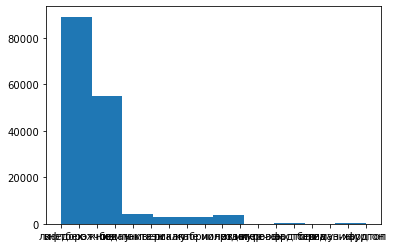

In [48]:
plt.hist(data.bodyType) #Признаки стоит укрупнить. Оставить три 

In [49]:
data.bodyType = data.bodyType.apply(lambda x: 1 if x=='внедорожник'
                                    else 2 if x=='седан'
                                    else 3)
data.bodyType.value_counts(normalize=True)

1    0.494405
2    0.290808
3    0.214787
Name: bodyType, dtype: float64

In [50]:
data.bodyType.unique()

array([3, 1, 2], dtype=int64)

### color

In [51]:
data.color.value_counts()

040001         36142
FAFBFB         28972
97948F         17899
чёрный         11010
0000CC         10928
CACECB         10527
белый           6133
200204          5770
EE1D19          5504
серебристый     4113
серый           3984
синий           3289
007F00          2458
C49648          2266
красный         1531
коричневый      1501
22A0F8          1096
зелёный          952
DEA522           640
бежевый          639
660099           615
FF8649           567
4A2197           529
голубой          457
FFD600           355
золотистый       266
пурпурный        254
фиолетовый       219
жёлтый           194
оранжевый        131
FFC0CB            27
розовый           13
Name: color, dtype: int64

In [52]:
color_dict = {'040001': 'чёрный', 'FAFBFB': 'белый', '97948F': 'серый', 'CACECB': 'серебристый', '0000CC': 'синий', '200204': 'коричневый',
              'EE1D19': 'красный',  '007F00': 'зелёный', 'C49648': 'бежевый', '22A0F8': 'голубой', '660099': 'пурпурный', 'DEA522': 'золотистый', 
              '4A2197': 'фиолетовый', 'FFD600': 'жёлтый', 'FF8649': 'оранжевый', 'FFC0CB': 'розовый'}

In [53]:
data.color.replace(to_replace=color_dict, inplace=True)
data.color.value_counts(normalize=True)

чёрный         0.296589
белый          0.220813
серый          0.137645
серебристый    0.092086
синий          0.089426
коричневый     0.045735
красный        0.044251
зелёный        0.021449
бежевый        0.018273
голубой        0.009768
золотистый     0.005699
пурпурный      0.005466
фиолетовый     0.004705
оранжевый      0.004390
жёлтый         0.003453
розовый        0.000252
Name: color, dtype: float64

(array([61369., 21883., 42376.,   869., 17545.,  7035.,  3959.,  1553.,
         1446.,   946.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

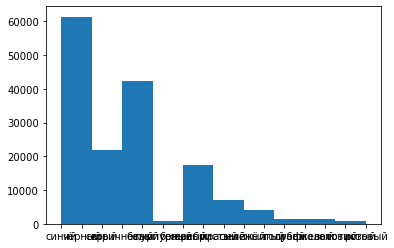

In [54]:
plt.hist(data.color) #Признаки стоит укрупнить. Оставить шесть

In [55]:
data.color = data.color.apply(lambda x: 1 if x=='чёрный'
                            else 2 if x=='белый'
                            else 3 if x=='серый'
                            else 4 if x=='серебристый'
                            else 5 if x=='синий'
                            else 6)
data.color.value_counts(normalize=True)

1    0.296589
2    0.220813
6    0.163441
3    0.137645
4    0.092086
5    0.089426
Name: color, dtype: float64

In [56]:
data.color.unique()

array([5, 1, 3, 6, 2, 4], dtype=int64)

### description 

In [57]:
data['descr_words_count'] = data.description.apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
data['descr_words_count'].replace([np.inf, -np.inf], 0, inplace=True)

In [58]:
data.drop(labels='description', axis=1, inplace=True)

### engineDisplacement

In [59]:
for x in data.engineDisplacement:
    x = float(x)

In [60]:
data.engineDisplacement.unique()

array([1.2, 1.6, 1.8, 2. , 1.4, 1.3, 1. , 3.6, 1.5, 1.9, 2.8, 1.1, 2.5,
       4.2, 3. , 4. , 5.9, 2.7, 3.1, 2.4, 5.2, 3.2, 4.1, 6.3, 2.3, 6. ,
       2.2, 3.7, 2.9, 5. , 3.3, 2.1, 2.6, nan, 3.5, 1.7, 0.7, 4.4, 4.8,
       5.4, 6.6, 4.9, 3.8, 3.4, 3.9, 4.6, 5.6, 4.5, 5.5, 6.2, 4.7, 4.3,
       5.8, 5.3, 5.7, 0. , 0.6])

### enginePower

In [61]:
data.enginePower.unique()

array(['105 N12', '110 N12', '152 N12', '200 N12', '102 N12', '150 N12',
       '90 N12', '180 N12', '220 N12', '122 N12', '70 N12', '140 N12',
       '125 N12', '54 N12', '86 N12', '75 N12', '64 N12', '95 N12',
       '260 N12', '170 N12', '80 N12', '68 N12', '160 N12', '115 N12',
       '280 N12', '53 N12', '60 N12', '143 N12', '42 N12', '101 N12',
       '58 N12', '193 N12', '79 N12', '30 N12', '100 N12', '50 N12',
       '163 N12', '225 N12', '420 N12', '211 N12', '245 N12', '560 N12',
       '500 N12', '249 N12', '450 N12', '605 N12', '250 N12', '354 N12',
       '120 N12', '290 N12', '230 N12', '350 N12', '204 N12', '255 N12',
       '340 N12', '177 N12', '272 N12', '372 N12', '210 N12', '130 N12',
       '300 N12', '190 N12', '239 N12', '435 N12', '333 N12', '271 N12',
       '326 N12', '238 N12', '310 N12', '233 N12', '252 N12', '133 N12',
       '460 N12', '520 N12', '400 N12', '525 N12', '367 N12', '265 N12',
       '550 N12', '580 N12', '88 N12', '165 N12', '430 N12', '335 N

In [62]:
data.enginePower = data.enginePower.apply(
    lambda x: float(x.replace("N12", "")) if isinstance(x, str) else x
)
data.enginePower.unique()

array([105., 110., 152., 200., 102., 150.,  90., 180., 220., 122.,  70.,
       140., 125.,  54.,  86.,  75.,  64.,  95., 260., 170.,  80.,  68.,
       160., 115., 280.,  53.,  60., 143.,  42., 101.,  58., 193.,  79.,
        30., 100.,  50., 163., 225., 420., 211., 245., 560., 500., 249.,
       450., 605., 250., 354., 120., 290., 230., 350., 204., 255., 340.,
       177., 272., 372., 210., 130., 300., 190., 239., 435., 333., 271.,
       326., 238., 310., 233., 252., 133., 460., 520., 400., 525., 367.,
       265., 550., 580.,  88., 165., 430., 335., 174., 224., 136., 256.,
       338., 112., 218., 360.,  93., 182., 113., 240., 270., 137., 155.,
        61., 254., 116.,  71., 285., 408., 166., 156., 257., 201., 162.,
       194., 142., 154., 147., 281., 243., 118., 128.,  91.,  83., 205.,
       247., 188., 295., 275.,  78., 109.,  94., 185., 258., 145., 132.,
       135.,  52.,  66., 124.,  98., 215., 158.,  99., 103., 131., 126.,
       235., 181., 315., 203., 231.,  82., 304., 17

### equipment_dict

In [63]:
data['equipment_dict_len'] = data.equipment_dict.apply(lambda x: int(len(re.findall('true',str(x)))))
data['equipment_dict_len'].replace([np.inf, -np.inf], 0, inplace=True)

In [64]:
data['equipment_dict_len'].head()

0    36
1    34
2    55
3    52
4    29
Name: equipment_dict_len, dtype: int64

In [65]:
data['equipment_dict_len'].isna().sum()

0

In [66]:
data.drop(labels='equipment_dict', axis=1, inplace=True)

### fuelType

In [67]:
data.fuelType.unique()

array(['бензин', 'дизель', 'гибрид', 'электро', 'газ', 'DIESEL',
       'GASOLINE', 'HYBRID', 'ELECTRO', 'LPG'], dtype=object)

In [68]:
data.fuelType = data.fuelType.apply(lambda x: "бензин" if x=='GASOLINE' 
                                    else "дизель" if x=="DIESEL" 
                                    else "гибрид" if x=="HYBRID"
                                    else "газ" if x=="LPG"
                                    else "электро" if x=="ELECTRO"
                                    else x)
data.fuelType.unique()

array(['бензин', 'дизель', 'гибрид', 'электро', 'газ'], dtype=object)

In [69]:
data.loc[(data.engineDisplacement.isna()) & (data.fuelType ==
                                                 'электро'), 'engineDisplacement'] = 0.0  # Для электромобидей fillna

In [70]:
data.engineDisplacement.isna().sum()

0

In [71]:
data.fuelType.value_counts(normalize=True)

бензин     0.767576
дизель     0.198376
гибрид     0.030834
электро    0.002472
газ        0.000742
Name: fuelType, dtype: float64

(array([1.2203e+05, 0.0000e+00, 3.1538e+04, 0.0000e+00, 0.0000e+00,
        4.9020e+03, 0.0000e+00, 3.9300e+02, 0.0000e+00, 1.1800e+02]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

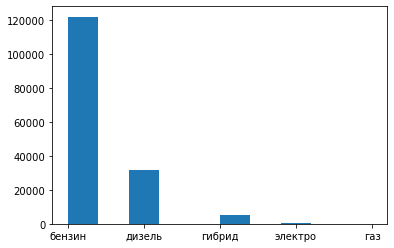

In [72]:
plt.hist(data.fuelType) #Признаки стоит укрупнить. Оставить три

In [73]:
data.fuelType = data.fuelType.apply(lambda x: 1 if x=="бензин"
                                    else 2 if x=="дизель" 
                                    else 3)
print(data.fuelType.unique())
data.fuelType.value_counts(normalize=True)

[1 2 3]


1    0.767576
2    0.198376
3    0.034048
Name: fuelType, dtype: float64

### modelDate

In [74]:
data.modelDate.unique()

array([2013., 2017., 2008., 2009., 2016., 2012., 2015., 2010., 2006.,
       2000., 2007., 1994., 2004., 1999., 2005., 1976., 2001., 1969.,
       1996., 1998., 1989., 1934., 2014., 2011., 2018., 1986., 1997.,
       1990., 2019., 2002., 1991., 1987., 1980., 1982., 1938., 1988.,
       2003., 1983., 1978., 1979., 1984., 1992., 1995., 1993., 1985.,
       1974., 1966., 1977., 1981., 1972., 1968., 1975., 1949., 1937.,
       1936., 1973., 1959., 1958., 2020., 1965., 1971., 1904., 1963.,
       1955., 1951., 1960., 2021., 1967., 1957.])

In [75]:
for x in data.modelDate:
    x = int(x)

### model_name

In [76]:
data.model_name.replace("_"," ")
data.model_name = data.model_name.apply(lambda x: x.lower())

In [77]:
print(data.model_name.nunique())
data.model_name.unique()

773


array(['octavia', 'superb', 'octavia_rs', 'yeti', 'kodiaq', 'rapid',
       'fabia', 'roomster', 'felicia', 'karoq', 'fabia_rs', '120',
       '100_series', 'favorit', 'popular', 'q5', 'r8', 'q7', 'q3', 'a4',
       'a3', 'a5', 'a6', 'rs7', 's6', 'rs6', 'allroad', 'tt', 's5', 's8',
       'a1', 'a8', '80', 'a7', 'rsq3', 'rs3', 'a4_allroad', 'q8', '100',
       'sq5', 's4', 'tt_rs', 'rs4', 's7', 'rs5', '90', 'coupe', 'a2',
       'tts', '920', 's3', '200', 'v8', 'e_tron', 'cr_v', 'accord',
       'pilot', 'civic', 'odyssey', 'stream', 'crosstour', 'elysion',
       'element', 'ridgeline', 'fit', 'hr_v', 'shuttle', 'freed',
       'odyssey_na', 'jazz', 'z', 'civic_ferio', 's2000', 'cr_z',
       'legend', 'stepwagon', 'civic_type_r', 'fr_v', 'cr_x', 'prelude',
       'mobilio_spike', 'n_box', 'zest', 'integra', 'inspire', 'vezel',
       'n_wgn', 'ascot', 'logo', 'acty', 'concerto', 'avancier', 'saber',
       'mobilio', 'crossroad', 'insight', 'torneo', 'airwave', 'domani',
       'rafa

In [78]:
most_pop_list = data.model_name.value_counts(normalize=True).head(25).index.tolist()
pop_list = data.model_name.value_counts(normalize=True).iloc[25:50].index.tolist()
less_pop_list = data.model_name.value_counts(normalize=True).tail(50).index.tolist()

In [79]:
data.model_name = data.model_name.apply(lambda x: 1 if x in most_pop_list
                                        else 2 if x in pop_list
                                        else 4 if x in less_pop_list
                                        else 3)
print(data.model_name.nunique())
data.model_name.value_counts(normalize=True)

4


1    0.442267
3    0.375768
2    0.181651
4    0.000315
Name: model_name, dtype: float64

### name 

In [80]:
data.name.unique()

array(['1.2 AMT (105 л.с.)', '1.6 MT (110 л.с.)',
       'DSG 1.8 AMT (152 л.с.)', ..., 'TOYOTA Cressida II (X50, X60)',
       'VOLKSWAGEN up! I Рестайлинг', 'VOLKSWAGEN Passat B2'],
      dtype=object)

In [81]:
data.drop(labels='name', axis=1, inplace=True)

### numberOfDoors

In [82]:
data.numberOfDoors.unique()

array([5., 4., 2., 3., 0.])

### productionDate

In [83]:
data.productionDate.unique()

array([2014, 2017, 2012, 2011, 2019, 2018, 2010, 2020, 2016, 2013, 2006,
       2007, 2015, 2005, 2008, 2009, 1997, 2004, 2002, 1987, 2003, 2001,
       1976, 2000, 1998, 1995, 1999, 1993, 1939, 1996, 1984, 1990, 1991,
       1992, 1989, 1982, 1985, 1994, 1938, 1981, 1988, 1983, 1980, 1986,
       1978, 1970, 1979, 1977, 1972, 1975, 1969, 1950, 1953, 1949, 1937,
       1959, 1968, 1936, 1904, 1974, 1967, 1961, 1960, 1965, 1963, 1957,
       1952, 1973, 1948, 2021], dtype=int64)

In [84]:
for x in data.productionDate:
    x = int(x)

### sell_id

In [85]:
data.sell_id.unique() 

array([1100575026, 1100549428, 1100658222, ..., 1101362518, 1101256068,
                0], dtype=int64)

In [86]:
data.drop(labels='sell_id', axis=1, inplace=True)

### vehicleConfiguration

In [87]:
data.vehicleConfiguration.unique()

array(['LIFTBACK ROBOT 1.2', 'LIFTBACK MECHANICAL 1.6',
       'LIFTBACK ROBOT 1.8', 'LIFTBACK AUTOMATIC 1.6',
       'LIFTBACK AUTOMATIC 1.8', 'LIFTBACK ROBOT 2.0',
       'ALLROAD_5_DOORS ROBOT 1.8', 'ALLROAD_5_DOORS MECHANICAL 1.4',
       'ALLROAD_5_DOORS MECHANICAL 1.8', 'LIFTBACK ROBOT 1.4',
       'ALLROAD_5_DOORS ROBOT 1.4', 'ALLROAD_5_DOORS ROBOT 2.0',
       'ALLROAD_5_DOORS MECHANICAL 1.2', 'LIFTBACK MECHANICAL 1.4',
       'HATCHBACK_5_DOORS AUTOMATIC 1.6',
       'HATCHBACK_5_DOORS MECHANICAL 1.2', 'ALLROAD_5_DOORS ROBOT 1.2',
       'SEDAN AUTOMATIC 1.8', 'COMPACTVAN AUTOMATIC 1.6',
       'WAGON_5_DOORS ROBOT 2.0', 'LIFTBACK MECHANICAL 1.8',
       'ALLROAD_5_DOORS AUTOMATIC 1.6', 'HATCHBACK_5_DOORS ROBOT 1.2',
       'WAGON_5_DOORS ROBOT 1.8', 'WAGON_5_DOORS AUTOMATIC 1.6',
       'HATCHBACK_5_DOORS MECHANICAL 1.3',
       'HATCHBACK_5_DOORS MECHANICAL 1.4', 'LIFTBACK MECHANICAL 1.2',
       'COMPACTVAN MECHANICAL 1.2', 'WAGON_5_DOORS MECHANICAL 1.2',
       'HATCHBACK_

In [88]:
data.drop(labels='vehicleConfiguration', axis=1, inplace=True)

### vehicleTransmission

In [89]:
data.vehicleTransmission.unique()

array(['роботизированная', 'механическая', 'автоматическая', 'вариатор',
       'AUTOMATIC', 'ROBOT', 'VARIATOR', 'MECHANICAL'], dtype=object)

In [90]:
data.vehicleTransmission.value_counts(normalize=True)

AUTOMATIC           0.428775
MECHANICAL          0.134513
VARIATOR            0.124386
автоматическая      0.123260
ROBOT               0.094150
механическая        0.045345
вариатор            0.025154
роботизированная    0.024418
Name: vehicleTransmission, dtype: float64

In [91]:
data.vehicleTransmission = data.vehicleTransmission.apply(lambda x: 1 if x=='MECHANICAL' or x=='механическая'
                                    else 2)
data.vehicleTransmission.unique()

array([2, 1], dtype=int64)

In [92]:
data.vehicleTransmission.value_counts(normalize=True)

2    0.820142
1    0.179858
Name: vehicleTransmission, dtype: float64

### vendor 

In [93]:
data.vendor.unique()

array(['EUROPEAN', 'JAPANESE'], dtype=object)

In [94]:
data.vendor = data.vendor.apply(lambda x: 1 if x=='EUROPEAN'
                                    else 2)
print(data.vendor.unique())
data.vendor.value_counts(normalize=True)

[1 2]


1    0.531743
2    0.468257
Name: vendor, dtype: float64

### owners

In [95]:
data['owners'].isna().sum(axis=0) * 100 / data.shape[0] #пропуски заменю "0", возможно продажа из автосалона

16.91837389373573

In [96]:
data.owners.unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца', 2.0, 3.0, 1.0,
       4.0, nan], dtype=object)

In [97]:
data.owners = data.owners.apply(lambda x: 1.0 if x=='1\xa0владелец' 
                                else 2.0 if x=='2\xa0владельца'
                                else 3.0 if x=='3 или более'
                                else x)
data.owners = data.owners.fillna(0)
data.owners.unique()

array([3., 1., 2., 4., 0.])

In [98]:
data.owners.value_counts(normalize=True)

1.0    0.285518
3.0    0.205622
2.0    0.202276
0.0    0.169184
4.0    0.137400
Name: owners, dtype: float64

### ownership

In [99]:
data['ownership'].isna().sum(axis=0) * 100 / data.shape[0] #слишком много невосполнимых  пропусков

14.27277473408772

In [100]:
data.drop(labels='ownership', axis=1, inplace=True)

### vehicle_licence

In [101]:
data['vehicle_licence'].isna().sum(axis=0) * 100 / data.shape[0]

0.7931765431089249

In [102]:
data.vehicle_licence.unique() #nan значения также будут считаться дубликатами

array(['Оригинал', 'Дубликат', nan, 'ORIGINAL', 'DUPLICATE'], dtype=object)

In [103]:
data.vehicle_licence = data.vehicle_licence.apply(
    lambda x: 1 if x == 'Оригинал' or x == 'ORIGINAL' else 2)
print(data.vehicle_licence.unique())
print(data.vehicle_licence.isna().sum())
data.vehicle_licence.value_counts(normalize=True)

[1 2]
0


1    0.882936
2    0.117064
Name: vehicle_licence, dtype: float64

### driving_gear

In [104]:
data.driving_gear.unique()

array(['передний', 'полный', 'задний', 'ALL_WHEEL_DRIVE',
       'FORWARD_CONTROL', 'REAR_DRIVE'], dtype=object)

In [105]:
data.driving_gear = data.driving_gear.apply(
    lambda x: 1 if x == 'передний' or x == 'FORWARD_CONTROL' 
    else 2 if x == 'полный' or x == 'ALL_WHEEL_DRIVE'
    else 3)
print(data.driving_gear.unique())
print(data.driving_gear.isna().sum())
data.driving_gear.value_counts(normalize=True)

[1 2 3]
0


2    0.507098
1    0.411332
3    0.081569
Name: driving_gear, dtype: float64

In [106]:
data.driving_gear = data.driving_gear.apply(lambda x: 1 if x == 3 else x) #требуется укрупнить признаки
print(data.driving_gear.unique())
print(data.driving_gear.isna().sum())
data.driving_gear.value_counts(normalize=True)

[1 2]
0


2    0.507098
1    0.492902
Name: driving_gear, dtype: float64

### steering_wheel 

In [107]:
data.steering_wheel.unique()

array(['Левый', 'Правый', 'LEFT', 'RIGHT'], dtype=object)

In [108]:
data.steering_wheel = data.steering_wheel.apply(lambda x: 1 if x == 'Левый' or x =='left' else 2)

print(data.steering_wheel.unique())
print(data.steering_wheel.isna().sum())
data.steering_wheel.value_counts(normalize=True)

[1 2]
0


2    0.790623
1    0.209377
Name: steering_wheel, dtype: float64

### condition

In [109]:
data.condition.unique()

array(['Не требует ремонта', nan], dtype=object)

In [110]:
data['condition'].isna().sum(axis=0) * 100 / data.shape[0] #nan заменю на 0 (требует ремонта)

78.18229851365886

In [111]:
data.condition = data.condition.apply(
    lambda x: 1 if x == 'Не требует ремонта'  
    else 0)
data.condition.unique()

array([1, 0], dtype=int64)

### customs

In [112]:
data.customs.unique()

array(['Растаможен', True], dtype=object)

In [113]:
data.customs = data.customs.apply(
    lambda x: 1 if x == 'Растаможен' or x == True else 0)
data.customs.unique()

array([1], dtype=int64)

## Проверка

In [114]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158981 entries, 0 to 158980
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             158981 non-null  int64  
 1   brand                158981 non-null  object 
 2   color                158981 non-null  int64  
 3   engineDisplacement   158981 non-null  float64
 4   enginePower          158981 non-null  float64
 5   fuelType             158981 non-null  int64  
 6   mileage              158981 non-null  int64  
 7   modelDate            158981 non-null  float64
 8   model_name           158981 non-null  int64  
 9   numberOfDoors        158981 non-null  float64
 10  productionDate       158981 non-null  int64  
 11  vehicleTransmission  158981 non-null  int64  
 12  vendor               158981 non-null  int64  
 13  owners               158981 non-null  float64
 14  vehicle_licence      158981 non-null  int64  
 15  driving_gear     

In [115]:
data.isna().sum(axis=0) * 100 / data.shape[0]

bodyType               0.0
brand                  0.0
color                  0.0
engineDisplacement     0.0
enginePower            0.0
fuelType               0.0
mileage                0.0
modelDate              0.0
model_name             0.0
numberOfDoors          0.0
productionDate         0.0
vehicleTransmission    0.0
vendor                 0.0
owners                 0.0
vehicle_licence        0.0
driving_gear           0.0
steering_wheel         0.0
condition              0.0
customs                0.0
price                  0.0
train                  0.0
descr_words_count      0.0
equipment_dict_len     0.0
dtype: float64

In [116]:
data.shape

(158981, 23)

## EDA

In [117]:
data.nunique(dropna=False) #для разделения по типам

bodyType                   3
brand                     12
color                      6
engineDisplacement        56
enginePower              362
fuelType                   3
mileage                26307
modelDate                 69
model_name                 4
numberOfDoors              5
productionDate            70
vehicleTransmission        2
vendor                     2
owners                     5
vehicle_licence            2
driving_gear               2
steering_wheel             2
condition                  2
customs                    1
price                  11248
train                      2
descr_words_count       1396
equipment_dict_len       114
dtype: int64

In [118]:
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'model_name', 
             'driving_gear', 'owners', 'numberOfDoors']
num_cols = ['engineDisplacement', 'enginePower',
            'mileage', 'modelDate', 'productionDate', 'descr_words_count', 'equipment_dict_len']
bin_cols = ['condition', 'customs', 'steering_wheel', 
            'vehicleTransmission', 'vendor', 'vehicle_licence']
help_cols = ['train']
target_cols = ['price']

all_cols = cat_cols + num_cols + bin_cols + help_cols + target_cols
len(all_cols)

23

### Анализ числовых столбцов: распределение, корреляция

In [119]:
#sns.pairplot(data[num_cols])

In [120]:
#plt.figure(figsize=(15, 8))
#sns.heatmap(data[data.train == 1][num_cols + ['price']
#                                      ].corr(), vmin=-1, vmax=1, annot=True, cmap='vlag')

In [121]:
#modelDate и productionDate сильно коррелированы
#enginePower и engineDisplacement также демонстрируют высокую корреляцию
cols_to_remove.extend(['productionDate', 'enginePower'])

In [122]:
data[num_cols].head()

,engineDisplacement,enginePower,mileage,modelDate,productionDate,descr_words_count,equipment_dict_len
0,1.2,105.0,74000,2013.0,2014,145,36
1,1.6,110.0,60563,2017.0,2017,357,34
2,1.8,152.0,88000,2013.0,2014,145,55
3,1.6,110.0,95000,2013.0,2014,238,52
4,1.8,152.0,58536,2008.0,2012,322,29


In [123]:
for x in num_cols:
    for i in data[x]:
        float(i)

In [124]:
for x in num_cols:
    transformer = RobustScaler().fit(data[x].values.reshape(-1,1))
    data[x] = transformer.transform(data[x].values.reshape(-1,1))

In [125]:
data[num_cols].head()

,engineDisplacement,enginePower,mileage,modelDate,productionDate,descr_words_count,equipment_dict_len
0,-0.666667,-0.660550,-0.220388,0.1,0.0,0.076923,36.0
1,-0.333333,-0.614679,-0.310034,0.5,0.3,1.164103,34.0
2,-0.166667,-0.229358,-0.126986,0.1,0.0,0.076923,55.0
3,-0.333333,-0.614679,-0.080286,0.1,0.0,0.553846,52.0
4,-0.166667,-0.229358,-0.323557,-0.4,-0.2,0.984615,29.0


### Работа с выбросами

In [126]:
data[(data.train == 1) & (data.enginePower >
                              data.query('train == 0').enginePower.max())]

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,...,owners,vehicle_licence,driving_gear,steering_wheel,condition,customs,price,train,descr_words_count,equipment_dict_len
34730,2,AUDI,3,-1.666667,4.302752,3,-0.707412,0.8,3,4.0,...,1.0,1,2,2,0,1,12100000.0,1,0.210256,0.0
49177,1,MERCEDES,1,1.666667,5.715596,1,-0.654040,0.6,3,5.0,...,1.0,1,2,2,0,1,17938461.0,1,0.046154,0.0
49234,1,MERCEDES,1,2.916667,4.798165,1,-0.140330,0.0,3,5.0,...,1.0,1,2,2,0,1,4007692.0,1,1.123077,0.0
49278,1,MERCEDES,1,1.666667,5.715596,1,-0.654040,0.6,3,5.0,...,1.0,1,2,2,0,1,16123076.0,1,2.456410,0.0
49307,1,MERCEDES,1,1.666667,4.798165,1,-0.413863,0.6,3,5.0,...,2.0,1,2,2,0,1,12361538.0,1,-0.564103,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98057,3,MERCEDES,1,3.333333,4.522936,1,-0.540623,-0.4,3,2.0,...,4.0,1,1,2,0,1,19923076.0,1,2.748718,0.0
100028,1,MERCEDES,1,2.916667,4.798165,1,-0.614010,0.3,3,5.0,...,1.0,1,2,2,0,1,9230769.0,1,-0.517949,0.0
122716,2,AUDI,3,-1.666667,4.302752,3,-0.709414,0.8,3,4.0,...,1.0,1,2,2,0,1,11000000.0,1,0.210256,0.0
137148,3,MERCEDES,1,3.333333,4.522936,1,-0.540623,-0.4,3,2.0,...,4.0,1,1,2,0,1,19923076.0,1,2.748718,0.0


In [127]:
data.drop(
    data[(data.train == 1) & (data.enginePower > data.query(
        'train == 0').enginePower.max())].index, inplace=True
)

In [128]:
cols_to_remove.extend(['condition', 'customs'])

In [129]:
cols_to_remove

['productionDate', 'enginePower', 'condition', 'customs']

### Анализ целевой характеристики («цены»)

In [130]:
#data.query('train == 1').price.hist();
#plt.title('The target variable distribution', fontdict={'fontsize': 14});
#plt.xlabel('price, RUB * 10^7')

In [131]:
#np.log2(data.query('train == 1').price).hist();
#plt.title('The log2 target variable distribution', fontdict={'fontsize': 14})

In [132]:
data['price_log2'] = np.log2(data.price + 1)

## Feature engineering

Число километров за один год

In [133]:
data['mileage_per_year'] = data.productionDate / data.mileage
data['mileage_per_year'].replace([np.inf, -np.inf], 0, inplace=True)

In [134]:
num_cols.append(['mileage_per_year'])

Возраст автомобиля

In [135]:
data['age_year'] = 2021 - data.productionDate
data['age_year'].replace([np.inf, -np.inf], 0, inplace=True)

In [136]:
data['time_bw_model_product'] = data.productionDate - data.modelDate
data.loc[data.time_bw_model_product < 0, 'time_bw_model_product'] = 0

In [137]:
num_cols.append(['age_year'])
num_cols.append(['time_bw_model_product'])

Раритетность и возраст

In [138]:
data['rarity'] = data.productionDate.apply(lambda x: 1 if x < 1960 else 0)
data['older_3y'] = data.productionDate.apply(lambda x: 1 if x < 2021 - 3 else 0)
data['older_5y'] = data.productionDate.apply(lambda x: 1 if x < 2021 - 5 else 0)

In [139]:
bin_cols.append(['older_3y', 'older_5y', 'rarity']) 

### Окончательные столбцы

In [140]:
data.drop(labels=cols_to_remove, axis=1, inplace=True)

In [141]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158887 entries, 0 to 158980
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   bodyType               158887 non-null  int64  
 1   brand                  158887 non-null  object 
 2   color                  158887 non-null  int64  
 3   engineDisplacement     158887 non-null  float64
 4   fuelType               158887 non-null  int64  
 5   mileage                158887 non-null  float64
 6   modelDate              158887 non-null  float64
 7   model_name             158887 non-null  int64  
 8   numberOfDoors          158887 non-null  float64
 9   vehicleTransmission    158887 non-null  int64  
 10  vendor                 158887 non-null  int64  
 11  owners                 158887 non-null  float64
 12  vehicle_licence        158887 non-null  int64  
 13  driving_gear           158887 non-null  int64  
 14  steering_wheel         158887 non-nu

In [142]:
cols_to_remove

['productionDate', 'enginePower', 'condition', 'customs']

In [143]:
num_cols, bin_cols, cat_cols

(['engineDisplacement',
  'enginePower',
  'mileage',
  'modelDate',
  'productionDate',
  'descr_words_count',
  'equipment_dict_len',
  ['mileage_per_year'],
  ['age_year'],
  ['time_bw_model_product']],
 ['condition',
  'customs',
  'steering_wheel',
  'vehicleTransmission',
  'vendor',
  'vehicle_licence',
  ['older_3y', 'older_5y', 'rarity']],
 ['bodyType',
  'brand',
  'color',
  'fuelType',
  'model_name',
  'driving_gear',
  'owners',
  'numberOfDoors'])

In [144]:
bin_cols = bin_cols[2:]

In [145]:
num_cols.remove('enginePower')
num_cols.remove('productionDate')

In [146]:
num_cols, bin_cols, cat_cols

(['engineDisplacement',
  'mileage',
  'modelDate',
  'descr_words_count',
  'equipment_dict_len',
  ['mileage_per_year'],
  ['age_year'],
  ['time_bw_model_product']],
 ['steering_wheel',
  'vehicleTransmission',
  'vendor',
  'vehicle_licence',
  ['older_3y', 'older_5y', 'rarity']],
 ['bodyType',
  'brand',
  'color',
  'fuelType',
  'model_name',
  'driving_gear',
  'owners',
  'numberOfDoors'])

## Кодирование категориальных признаков

In [147]:
data = pd.get_dummies(data, columns=cat_cols)

In [148]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158887 entries, 0 to 158980
Data columns (total 58 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   engineDisplacement     158887 non-null  float64
 1   mileage                158887 non-null  float64
 2   modelDate              158887 non-null  float64
 3   vehicleTransmission    158887 non-null  int64  
 4   vendor                 158887 non-null  int64  
 5   vehicle_licence        158887 non-null  int64  
 6   steering_wheel         158887 non-null  int64  
 7   price                  158887 non-null  float64
 8   train                  158887 non-null  int64  
 9   descr_words_count      158887 non-null  float64
 10  equipment_dict_len     158887 non-null  float64
 11  price_log2             158887 non-null  float64
 12  mileage_per_year       158887 non-null  float64
 13  age_year               158887 non-null  float64
 14  time_bw_model_product  158887 non-nu

In [149]:
data = pd.get_dummies(data, columns=bin_cols[:4])

In [150]:
len(data.columns)

62

## Dimensionality reduction

Не дало прироста метрики, при снижении размеренности метрика понижается. 
Принято решение от понижения размеренности отказаться.

In [151]:
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [152]:
#X_ = data.query('train == 1').drop(['price', 'train', 'price_log2',], axis=1)
#X_t_ = data.query('train == 0').drop(['price', 'train', 'price_log2',], axis=1)
#y = data.query('train == 1').price

In [153]:
#clf = LinearDiscriminantAnalysis()

#X = clf.fit(X_, y).transform(X_)
#X_t = clf.transform(X_t_)

## Machine learning

In [154]:
# Импровизированная метрика (т.к. новая версия с метрикой не была доступна)
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.ones(len(y_true)), np.abs(y_true))))*100

In [155]:
print(data.query('train == 1').shape)
new_data = data.query('train == 1').copy()
new_data.drop_duplicates(inplace=True) #После заполнения проопусков появились еще дубликаты. Удаляю
new_data.shape

(124201, 62)


(93065, 62)

In [156]:
X = new_data.drop(['price', 'train', 'price_log2',], axis=1)
X_t = data.query('train == 0').drop(['price', 'train', 'price_log2',], axis=1)
y = new_data.price

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

## LinearRegression

In [423]:
reg = LinearRegression()
reg.fit(X_train, np.log(y_train))

LinearRegression()

In [424]:
y_pred = np.exp(reg.predict(X_test))
reg_mape_value = round(mape(y_test, y_pred)/100,2)

In [425]:
print (f"Точность прогноза: {1 - reg_mape_value}")

Точность прогноза: 0.76


## LazyRegressor

In [164]:
#mae = mean_absolute_error
#regr=LazyRegressor(verbose=0,predictions=True, custom_metric=mae)
## fit and train the model
#start_time_2=time.time()
#models, predictions=regr.fit(X_train, X_test, np.log(y_train), np.log(y_test))
#end_time_2=time.time()

100%|███████████████████████████████████████| 42/42 [1:45:59<00:00, 151.42s/it]


In [165]:
#models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken,mean_absolute_error
Model,,,,,
RandomForestRegressor,0.95,0.95,0.23,70.27,0.13
ExtraTreesRegressor,0.95,0.95,0.23,81.72,0.13
BaggingRegressor,0.94,0.94,0.24,7.75,0.14
XGBRegressor,0.94,0.94,0.24,23.13,0.15
LGBMRegressor,0.93,0.93,0.25,6.20,0.16
HistGradientBoostingRegressor,0.93,0.93,0.25,36.73,0.17
NuSVR,0.93,0.93,0.25,3543.64,0.16
SVR,0.93,0.93,0.25,2260.76,0.16
MLPRegressor,0.93,0.93,0.27,63.20,0.18


In [ ]:
#RandomForestRegressor	0.13
#ExtraTreesRegressor	0.13
#BaggingRegressor	0.14
#XGBRegressor	0.15

## Random Forest

In [162]:
# y_train

#rf = RandomForestRegressor(random_state = 42)
#rf.fit(X_train, y_train)
#y_pred = (rf.predict(X_test))
#rf_mape_value = round(mape(y_test, y_pred)/100,2)
#print (f"Точность прогноза: {1 - rf_mape_value}")

Точность прогноза: 0.84

In [175]:
# np.log(y_train)

#rf = RandomForestRegressor(random_state = 42)
#rf.fit(X_train, np.log(y_train))
#y_pred = np.exp(rf.predict(X_test))
#rf_mape_value = round(mape(y_test, y_pred)/100,2)
#print (f"Точность прогноза: {1 - rf_mape_value}")

Точность прогноза: 0.87

In [164]:
#random_grid = {'n_estimators': [int(x) for x in np.linspace(start=100, stop=400, num=4)],
#               'max_features': ['auto', 'sqrt', 'log2'],
#               'max_depth': [int(x) for x in np.linspace(5, 15, num=6)] + [None],
#               'min_samples_split': [2, 5, 10],
#               'min_samples_leaf': [1, 2, 4],
#               'bootstrap': [True, False]}

#rf = RandomForestRegressor(random_state=42)
#rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                             #n_iter=100, cv=3, verbose=10, random_state=42, n_jobs=-1)

#rf_random.fit(X_train, np.log(y_train))
#rf_random.best_params_

{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [158]:
#best_rf = rf_random.best_estimator_
best_rf = RandomForestRegressor(random_state=42, n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features='auto', max_depth=None, bootstrap=True)
best_rf.fit(X_train, np.log(y_train))
y_pred = np.exp(best_rf.predict(X_test))
best_mape_value = round(mape(y_test, y_pred)/100,2)
print (f"Точность прогноза: {1 - best_mape_value}")

Точность прогноза: 0.87


In [160]:
#y_sub = (best.predict(X_t))
#sample_submission = pd.read_csv("sample_submission.csv", low_memory=False, encoding='utf-8')
#sample_submission['price'] = y_sub
#sample_submission.to_csv(f'submission_rfr.csv', index=False)

In [161]:
#Точность модели MAPE 13
#Точность модели на kaggle MAPE 99.99736

## XGBRegressor

In [158]:
xgb_log = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.05, max_depth=14, alpha=1,
                           n_estimators=2000, random_state=42, n_jobs=-1)

In [159]:
xgb_log.fit(X_train, np.log(y_train))
y_pred = np.exp(xgb_log.predict(X_test))
xgb_log_mape_value = round(mape(y_test, y_pred)/100,2)
print (f"Точность прогноза: {1 - xgb_log_mape_value}")

Точность прогноза: 0.87


In [434]:
#y_sub = (xgb_log.predict(X_t))
#sample_submission = pd.read_csv("sample_submission.csv", low_memory=False, encoding='utf-8')
#sample_submission['price'] = y_sub
#sample_submission.to_csv(f'submission_xgbr.csv', index=False)
#sample_submission.head(10)

,sell_id,price
0,1100575026,13.569694
1,1100549428,13.734769
2,1100658222,13.795814
3,1100937408,13.537584
4,1101037972,13.469167
5,1100912634,13.583899
6,1101228730,13.417316
7,1100165896,13.161449
8,1100768262,14.613574
9,1101218501,13.597955


In [165]:
#Точность модели MAPE 10
#Точность модели на kaggle MAPE 18.82620

## Cat boost

In [160]:
model = CatBoostRegressor(iterations = 10000,
                          random_seed = 42,
                          eval_metric='MAPE',
                          silent=True,
                         )

In [161]:
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         )

In [163]:
y_pred = model.predict(X_test)
cat_log_mape_value = round(mape(y_test, y_pred)/100,2)
print (f"Точность прогноза: {1 - cat_log_mape_value}")

Точность прогноза: 0.84


In [438]:
#y_sub = (model.predict(X_t))
#sample_submission = pd.read_csv("sample_submission.csv", low_memory=False, encoding='utf-8')
#sample_submission['price'] = y_sub
#sample_submission.to_csv(f'submission_cat.csv', index=False)

In [ ]:
#Точность модели MAPE 17
#Точность модели на kaggle MAPE 27.57761

## ExtraTreesRegressor

In [170]:
# y_train

#etr = ExtraTreesRegressor(random_state = 42)
#etr.fit(X_train, y_train)
#y_pred = etr.predict(X_test)
#etr_mape_value = round(mape(y_test, y_pred)/100,2)
#print (f"Точность прогноза: {1 - etr_mape_value}")

Точность прогноза: 0.84

In [173]:
# np.log(y_train)

#etr = ExtraTreesRegressor(random_state = 42)
#etr.fit(X_train,np.log(y_train))
#y_pred = np.exp(etr.predict(X_test))
#etr_mape_value = round(mape(y_test, y_pred)/100,2)
#print (f"Точность прогноза: {1 - etr_mape_value}")

Точность прогноза: 0.87

In [175]:
#random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 400, num = 4)],
#            'max_features': ['auto', 'sqrt','log2'],
#            'max_depth': [int(x) for x in np.linspace(5, 15, num = 6)] + [None],
#            'min_samples_split': [2, 5, 10],
#            'min_samples_leaf': [1, 2, 4],               
#            'bootstrap': [True, False]}

#etr = ExtraTreesRegressor(random_state = 42)
#etr_r = RandomizedSearchCV(estimator = etr, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=10, random_state=42, n_jobs = -1)
#etr_r.fit(X_train, np.log(y_train))
#etr_r.best_params_

{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [162]:
#best_etr = etr_r.best_estimator_
best_etr = ExtraTreesRegressor(random_state = 42, n_estimators=300, 
                                min_samples_split=2, min_samples_leaf=1, max_features='auto', max_depth=None, bootstrap=True)
best_etr.fit(X_train, np.log(y_train))
y_pred = np.exp(best_etr.predict(X_test))
best_mape_value = round(mape(y_test, y_pred)/100,2)
print (f"Точность прогноза: {1 - best_mape_value}")

Точность прогноза: 0.87


In [ ]:
#Точность прогноза: 0.87

In [440]:
#y_sub = (best_etr.predict(X_t))
#sample_submission = pd.read_csv("sample_submission.csv", low_memory=False, encoding='utf-8')
#sample_submission['price'] = y_sub
#sample_submission.to_csv(f'submission_etr.csv', index=False)

In [ ]:
#Точность модели MAPE 13
#Точность модели на kaggle MAPE 99.99736

## BaggingRegressor

In [165]:
best_rf = RandomForestRegressor(random_state=42, n_estimators=300, 
                                min_samples_split=2, min_samples_leaf=1, max_features='auto', max_depth=None, bootstrap=True)

In [ ]:
bagg_rf = BaggingRegressor(best_rf, n_jobs=1, random_state=42)
bagg_rf.fit(X_train, np.log(y_train))
y_pred = np.exp(bagg_rf.predict(X_test))
best_mape_value = round(mape(y_test, y_pred)/100,2)
print (f"Точность прогноза: {1 - best_mape_value}")

In [ ]:
#y_sub = (bagg_rf.predict(X_t))
#sample_submission = pd.read_csv("sample_submission.csv", low_memory=False, encoding='utf-8')
#sample_submission['price'] = y_sub
#sample_submission.to_csv(f'submission_bagg_rf.csv', index=False)

In [ ]:
#Точность модели MAPE 
#Точность модели на kaggle MAPE 

In [ ]:
best_etr = ExtraTreesRegressor(random_state = 42, n_estimators=300, 
                                min_samples_split=2, min_samples_leaf=1, max_features='auto', max_depth=None, bootstrap=True)

In [ ]:
bagg_etr = BaggingRegressor(best_etr, n_jobs=1, random_state=42)
bagg_etr.fit(X_train, np.log(y_train))
y_pred = np.exp(bagg_etr.predict(X_test))
best_mape_value = round(mape(y_test, y_pred)/100,2)
print (f"Точность прогноза: {1 - best_mape_value}")

In [ ]:
#y_sub = (bagg_etr.predict(X_t))
#sample_submission = pd.read_csv("sample_submission.csv", low_memory=False, encoding='utf-8')
#sample_submission['price'] = y_sub
#sample_submission.to_csv(f'submission_bagg_etr.csv', index=False)

In [ ]:
#Точность модели MAPE 
#Точность модели на kaggle MAPE

In [ ]:
xgb_log = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.05, max_depth=14, alpha=1,
                           n_estimators=2000, random_state=42, n_jobs=-1)

In [ ]:
bagg_xgb = BaggingRegressor(xgb_log, n_jobs=1, random_state=42)
bagg_xgb.fit(X_train, np.log(y_train))
y_pred = np.exp(bagg_xgb.predict(X_test))
best_mape_value = round(mape(y_test, y_pred)/100,2)
print (f"Точность прогноза: {1 - best_mape_value}")

In [ ]:
#y_sub = (bagg_xgb.predict(X_t))
#sample_submission = pd.read_csv("sample_submission.csv", low_memory=False, encoding='utf-8')
#sample_submission['price'] = y_sub
#sample_submission.to_csv(f'submission_bagg_xgb.csv', index=False)

In [ ]:
#Точность модели MAPE 
#Точность модели на kaggle MAPE

## StackingRegressor

In [ ]:
#best_etr = ExtraTreesRegressor(random_state = 42, n_estimators=300, 
#                                min_samples_split=2, min_samples_leaf=1, max_features='auto', max_depth=None, bootstrap=True)
#xgb_log = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.05, max_depth=14, alpha=1,
#                           n_estimators=2000, random_state=42, n_jobs=-1)

In [164]:
estimators = [('etr',best_etr),
              ('xgb_reg',xgb_log)]

st_r = StackingRegressor(estimators=estimators,final_estimator=LinearRegression())

st_r.fit(X_train, np.log(y_train))
y_pred = np.exp(st_r.predict(X_test))
best_mape_value = round(mape(y_test, y_pred)/100,2)
print (f"Точность прогноза: {1 - best_mape_value}")

Точность прогноза: 0.88


In [165]:
y_sub = (st_r.predict(X_t))
sample_submission = pd.read_csv("sample_submission.csv", low_memory=False, encoding='utf-8')
sample_submission['price'] = y_sub
sample_submission.to_csv(f'submission_st_r.csv', index=False)

In [ ]:
#Точность модели MAPE 12
#Точность модели на kaggle MAPE 99.99736

In [166]:
estimators = [('etr',best_etr),
              ('xgb_reg',xgb_log)]

st_cat = StackingRegressor(estimators=estimators,final_estimator=CatBoostRegressor())
st_cat.fit(X_train, np.log(y_train))
y_pred = np.exp(st_cat.predict(X_test))
best_mape_value = round(mape(y_test, y_pred)/100,2)
print (f"Точность прогноза: {1 - best_mape_value}")

Learning rate set to 0.080898
0:	learn: 0.9148231	total: 9.06ms	remaining: 9.05s
1:	learn: 0.8496937	total: 16ms	remaining: 8.01s
2:	learn: 0.7893119	total: 23.3ms	remaining: 7.74s
3:	learn: 0.7337400	total: 30.7ms	remaining: 7.64s
4:	learn: 0.6836660	total: 38.4ms	remaining: 7.63s
5:	learn: 0.6370725	total: 46.9ms	remaining: 7.76s
6:	learn: 0.5948781	total: 54.3ms	remaining: 7.7s
7:	learn: 0.5561664	total: 62ms	remaining: 7.68s
8:	learn: 0.5206345	total: 69.5ms	remaining: 7.65s
9:	learn: 0.4885440	total: 76.9ms	remaining: 7.61s
10:	learn: 0.4594455	total: 84.3ms	remaining: 7.58s
11:	learn: 0.4330431	total: 92.2ms	remaining: 7.59s
12:	learn: 0.4092719	total: 99.7ms	remaining: 7.57s
13:	learn: 0.3874841	total: 107ms	remaining: 7.55s
14:	learn: 0.3680426	total: 115ms	remaining: 7.58s
15:	learn: 0.3505526	total: 123ms	remaining: 7.56s
16:	learn: 0.3350240	total: 131ms	remaining: 7.56s
17:	learn: 0.3207187	total: 138ms	remaining: 7.55s
18:	learn: 0.3082049	total: 146ms	remaining: 7.54s
19:

172:	learn: 0.2152916	total: 1.27s	remaining: 6.08s
173:	learn: 0.2152596	total: 1.28s	remaining: 6.07s
174:	learn: 0.2152285	total: 1.29s	remaining: 6.06s
175:	learn: 0.2152005	total: 1.29s	remaining: 6.06s
176:	learn: 0.2151709	total: 1.3s	remaining: 6.05s
177:	learn: 0.2151531	total: 1.31s	remaining: 6.04s
178:	learn: 0.2151249	total: 1.31s	remaining: 6.03s
179:	learn: 0.2150964	total: 1.32s	remaining: 6.03s
180:	learn: 0.2150747	total: 1.33s	remaining: 6.02s
181:	learn: 0.2150589	total: 1.34s	remaining: 6.01s
182:	learn: 0.2150498	total: 1.34s	remaining: 6s
183:	learn: 0.2150299	total: 1.35s	remaining: 5.99s
184:	learn: 0.2150078	total: 1.36s	remaining: 5.99s
185:	learn: 0.2149975	total: 1.37s	remaining: 5.98s
186:	learn: 0.2149730	total: 1.37s	remaining: 5.97s
187:	learn: 0.2149555	total: 1.38s	remaining: 5.96s
188:	learn: 0.2149349	total: 1.39s	remaining: 5.95s
189:	learn: 0.2149145	total: 1.39s	remaining: 5.95s
190:	learn: 0.2148972	total: 1.4s	remaining: 5.94s
191:	learn: 0.214

352:	learn: 0.2127933	total: 2.56s	remaining: 4.68s
353:	learn: 0.2127794	total: 2.56s	remaining: 4.67s
354:	learn: 0.2127735	total: 2.57s	remaining: 4.67s
355:	learn: 0.2127658	total: 2.58s	remaining: 4.66s
356:	learn: 0.2127455	total: 2.58s	remaining: 4.65s
357:	learn: 0.2127368	total: 2.59s	remaining: 4.65s
358:	learn: 0.2127315	total: 2.6s	remaining: 4.64s
359:	learn: 0.2127260	total: 2.61s	remaining: 4.63s
360:	learn: 0.2127196	total: 2.61s	remaining: 4.63s
361:	learn: 0.2127103	total: 2.62s	remaining: 4.62s
362:	learn: 0.2127063	total: 2.63s	remaining: 4.61s
363:	learn: 0.2126992	total: 2.63s	remaining: 4.61s
364:	learn: 0.2126932	total: 2.64s	remaining: 4.6s
365:	learn: 0.2126853	total: 2.65s	remaining: 4.59s
366:	learn: 0.2126804	total: 2.66s	remaining: 4.58s
367:	learn: 0.2126753	total: 2.66s	remaining: 4.58s
368:	learn: 0.2126686	total: 2.67s	remaining: 4.57s
369:	learn: 0.2126599	total: 2.68s	remaining: 4.56s
370:	learn: 0.2126549	total: 2.69s	remaining: 4.55s
371:	learn: 0.

527:	learn: 0.2113913	total: 3.82s	remaining: 3.41s
528:	learn: 0.2113854	total: 3.83s	remaining: 3.4s
529:	learn: 0.2113808	total: 3.83s	remaining: 3.4s
530:	learn: 0.2113767	total: 3.84s	remaining: 3.39s
531:	learn: 0.2113681	total: 3.85s	remaining: 3.38s
532:	learn: 0.2113625	total: 3.85s	remaining: 3.38s
533:	learn: 0.2113516	total: 3.86s	remaining: 3.37s
534:	learn: 0.2113451	total: 3.87s	remaining: 3.36s
535:	learn: 0.2113394	total: 3.88s	remaining: 3.35s
536:	learn: 0.2113328	total: 3.88s	remaining: 3.35s
537:	learn: 0.2113270	total: 3.89s	remaining: 3.34s
538:	learn: 0.2113187	total: 3.9s	remaining: 3.33s
539:	learn: 0.2113131	total: 3.9s	remaining: 3.33s
540:	learn: 0.2113034	total: 3.91s	remaining: 3.32s
541:	learn: 0.2112992	total: 3.92s	remaining: 3.31s
542:	learn: 0.2112917	total: 3.93s	remaining: 3.3s
543:	learn: 0.2112887	total: 3.93s	remaining: 3.3s
544:	learn: 0.2112843	total: 3.94s	remaining: 3.29s
545:	learn: 0.2112802	total: 3.95s	remaining: 3.28s
546:	learn: 0.2112

702:	learn: 0.2103238	total: 5.11s	remaining: 2.16s
703:	learn: 0.2103212	total: 5.12s	remaining: 2.15s
704:	learn: 0.2103184	total: 5.12s	remaining: 2.14s
705:	learn: 0.2103140	total: 5.13s	remaining: 2.14s
706:	learn: 0.2103109	total: 5.14s	remaining: 2.13s
707:	learn: 0.2103061	total: 5.14s	remaining: 2.12s
708:	learn: 0.2102982	total: 5.15s	remaining: 2.12s
709:	learn: 0.2102935	total: 5.16s	remaining: 2.11s
710:	learn: 0.2102846	total: 5.17s	remaining: 2.1s
711:	learn: 0.2102811	total: 5.18s	remaining: 2.09s
712:	learn: 0.2102760	total: 5.18s	remaining: 2.09s
713:	learn: 0.2102690	total: 5.19s	remaining: 2.08s
714:	learn: 0.2102665	total: 5.2s	remaining: 2.07s
715:	learn: 0.2102580	total: 5.21s	remaining: 2.07s
716:	learn: 0.2102509	total: 5.22s	remaining: 2.06s
717:	learn: 0.2102476	total: 5.22s	remaining: 2.05s
718:	learn: 0.2102441	total: 5.23s	remaining: 2.04s
719:	learn: 0.2102327	total: 5.24s	remaining: 2.04s
720:	learn: 0.2102273	total: 5.25s	remaining: 2.03s
721:	learn: 0.

871:	learn: 0.2094863	total: 6.39s	remaining: 938ms
872:	learn: 0.2094822	total: 6.4s	remaining: 931ms
873:	learn: 0.2094752	total: 6.4s	remaining: 923ms
874:	learn: 0.2094662	total: 6.41s	remaining: 916ms
875:	learn: 0.2094590	total: 6.42s	remaining: 909ms
876:	learn: 0.2094554	total: 6.43s	remaining: 902ms
877:	learn: 0.2094499	total: 6.43s	remaining: 894ms
878:	learn: 0.2094475	total: 6.44s	remaining: 887ms
879:	learn: 0.2094449	total: 6.45s	remaining: 879ms
880:	learn: 0.2094415	total: 6.46s	remaining: 872ms
881:	learn: 0.2094329	total: 6.46s	remaining: 865ms
882:	learn: 0.2094319	total: 6.47s	remaining: 857ms
883:	learn: 0.2094282	total: 6.48s	remaining: 850ms
884:	learn: 0.2094245	total: 6.49s	remaining: 843ms
885:	learn: 0.2094200	total: 6.49s	remaining: 836ms
886:	learn: 0.2094141	total: 6.5s	remaining: 828ms
887:	learn: 0.2094012	total: 6.51s	remaining: 821ms
888:	learn: 0.2093983	total: 6.52s	remaining: 814ms
889:	learn: 0.2093948	total: 6.52s	remaining: 806ms
890:	learn: 0.2

In [167]:
#y_sub = (st_cat.predict(X_t))
#sample_submission = pd.read_csv("sample_submission.csv", low_memory=False, encoding='utf-8')
#sample_submission['price'] = y_sub
#sample_submission.to_csv(f'submission_st_cat.csv', index=False)

In [ ]:
#Точность модели MAPE 12
#Точность модели на kaggle MAPE 99.99736

# Вывод.

Наилучших показателей удалось достичь с использованием XGBRegressor.